<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20230217.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta 
import os
import re

from functools import reduce
from collections import defaultdict 
from scipy import stats 
from scipy.stats import norm

# Customer Analysis

In [2]:
np.sort(os.listdir())

array(['.config', '1_customers_dataset.csv',
       '1_order_payments_dataset.csv', '1_orders_dataset.csv',
       'KPMG_VI_New_raw_data_update_final.csv',
       'KPMG_VI_New_raw_data_update_final.xlsx',
       'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv',
       'WA_Fn-UseC_-Telco-Customer-Churn.csv', 'ab_experiment.csv',
       'app_wau.csv', 'bz_data_analyis.csv', 'cookie_cats.csv',
       'ecommerce-data.csv', 'groceries.csv', 'lead_conversion.csv',
       'mall_customers.csv', 'match_result_test.csv',
       'mock_sales_data.csv', 'online_retail.xlsx',
       'online_retail_II.xlsx', 'sales.csv', 'sales_data_with_stores.csv',
       'sales_vs_discount.csv', 'sample-sales-data.csv', 'sample_data',
       'scanner_data.csv', 'test.csv'], dtype='<U49')

In [3]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
cnt = pd.melt(df, id_vars = ['userid','version','sum_gamerounds'], var_name = 'retention', value_name = 'result')
cnt = cnt.groupby(['version','retention','result'])['userid'].count().reset_index().rename(columns = {'userid':'cnt'})
cnt = cnt[cnt['result'] == True]
cnt

,version,retention,result,cnt
1,gate_30,retention_1,True,20034
3,gate_30,retention_7,True,8502
5,gate_40,retention_1,True,20119
7,gate_40,retention_7,True,8279


[]

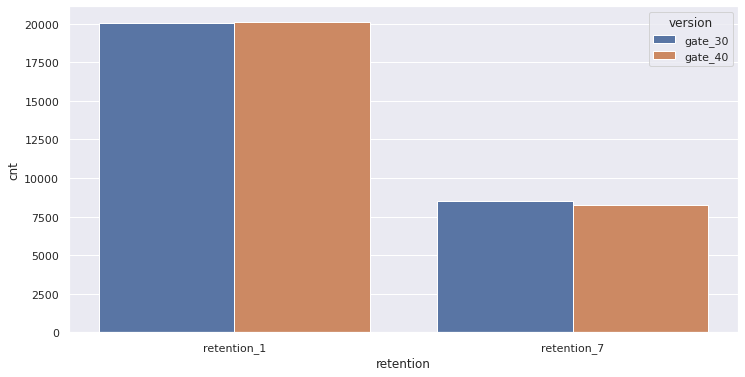

In [7]:
sns.set(rc = {'figure.figsize':[12,6]})
sns.barplot(data = cnt, x = 'retention', y = 'cnt', hue = 'version')
plt.plot()

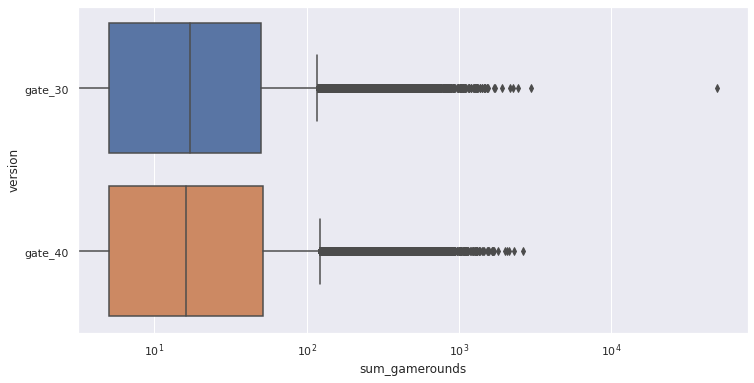

In [10]:
sns.set(rc = {'figure.figsize':[12,6]})
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
ax.set_xscale('log')
plt.show()

In [11]:
df = df[df['sum_gamerounds'] <= 10000]

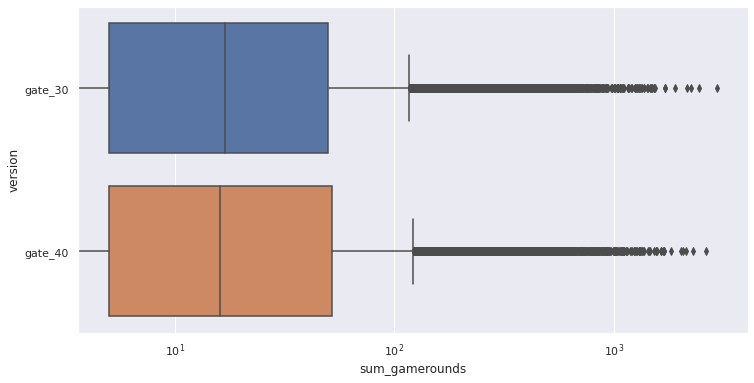

In [12]:
sns.set(rc = {'figure.figsize':[12,6]})
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
ax.set_xscale('log')
plt.show()

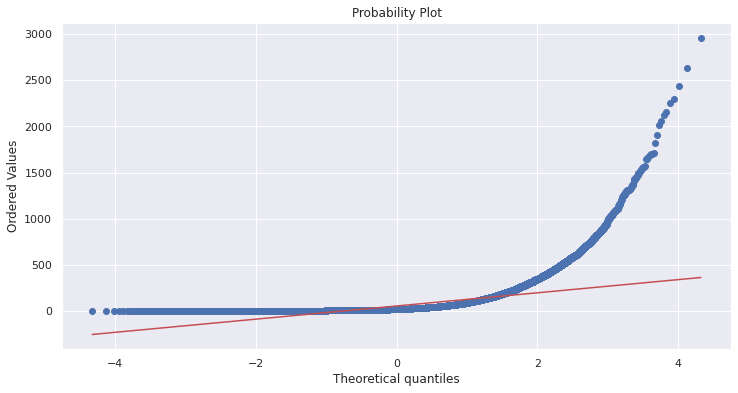

In [13]:
stats.probplot(df['sum_gamerounds'], dist = 'norm', plot = plt)
plt.show()

In [14]:
stat, p = stats.chisquare(df['sum_gamerounds'])
print(str(stat), '\t', str(p))

18528909.99029161 	 0.0


In [15]:
n = 1000
boots = pd.DataFrame(
    [df.sample(frac = .1, replace = True).groupby(['version'])['sum_gamerounds'].mean() for i in range(n)]
)
boots.head()

version,gate_30,gate_40
sum_gamerounds,50.409050,53.629826
sum_gamerounds,50.698342,50.460391
sum_gamerounds,49.578022,52.130007
sum_gamerounds,52.153273,54.000000
sum_gamerounds,51.100903,48.021138


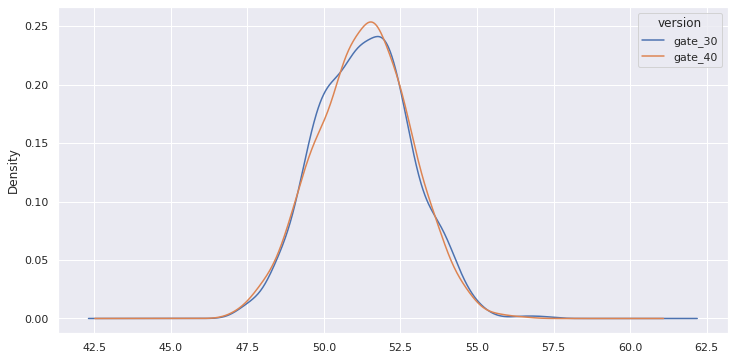

In [17]:
boots.plot.kde()

In [18]:
diff = boots['gate_30'] - boots['gate_40']
len(diff[diff > 0])/n

0.505

In [19]:
z_mean = np.mean(boots['gate_30']) - np.mean(boots['gate_40'])
z_sigma = np.sqrt(
    np.var(boots['gate_30'])/n + np.var(boots['gate_40'])/n
)
alpha = .5
ci_diff = [z_mean - norm.ppf(1-alpha/2)*z_sigma, z_mean + norm.ppf(1-alpha/2)*z_sigma]

In [20]:
print(f'Z Mean {z_mean}')
print(f'Z Sgima {z_sigma}')
print(f'CI : {ci_diff[0]} {ci_diff[1]}')

Z Mean 0.012169977327502579
Z Sgima 0.06864441781746884
CI : -0.03412997889855744 0.0584699335535626


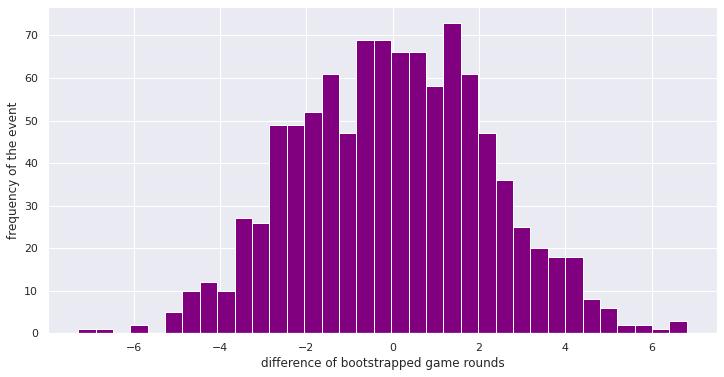

In [22]:
plt.hist(diff, bins = 35, color = 'purple')
plt.xlabel('difference of bootstrapped game rounds')
plt.ylabel('frequency of the event')
plt.show()

## Anderson Test

In [24]:
res = stats.anderson(df['sum_gamerounds'])
res

AndersonResult(statistic=13369.548966017013, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [29]:
[f'Probably Gaussian : Crit : {crit}, Sig {sig}' 
 if crit > sig else
 f'Probably not Gaussian : Crit : {crit}, Sig {sig}' 
 for sig, crit in zip(res.significance_level, res.critical_values)]

['Probably not Gaussian : Crit : 0.576, Sig 15.0',
 'Probably not Gaussian : Crit : 0.656, Sig 10.0',
 'Probably not Gaussian : Crit : 0.787, Sig 5.0',
 'Probably not Gaussian : Crit : 0.918, Sig 2.5',
 'Probably Gaussian : Crit : 1.092, Sig 1.0']

In [39]:
res.significance_level

array([15. , 10. ,  5. ,  2.5,  1. ])

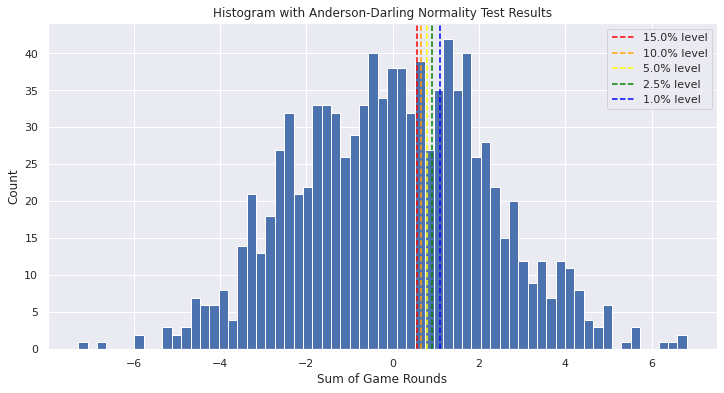

In [41]:
line_colors = ['red', 'orange', 'yellow', 'green', 'blue']
# Create histogram of data
plt.hist(diff, bins=65)

# Calculate critical values
crit_vals = res.critical_values

# Add vertical lines for each critical value
for i, (crit_val, sig_level) in enumerate(zip(crit_vals, res.significance_level)):
    plt.axvline(crit_val, color=line_colors[i], linestyle='--', label=f'{sig_level}% level')


# Add legend, title, and axis labels
plt.legend()
plt.title('Histogram with Anderson-Darling Normality Test Results')
plt.xlabel('Sum of Game Rounds')
plt.ylabel('Count')

plt.show()

# Iterators

In [42]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [43]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}